In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 500)

from my_imports import acf_plot
from my_imports import sarimax_plot, sarimax_eval
from File_creation import gap_less

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

## Creating Dissolved Oxygen Dataset

In [3]:
#created aggregated dataframe with which averages the data from all of the sites.
agg_data = gap_less.groupby(gap_less.index).mean()

In [4]:
#creating dissolved only dataframe
do_data = agg_data[['dissolved_oxygen', 'water_temperature']]

In [5]:
do_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 233 entries, 1996-06-08 to 2018-12-10
Data columns (total 2 columns):
dissolved_oxygen     233 non-null float64
water_temperature    233 non-null float64
dtypes: float64(2)
memory usage: 5.5 KB


In [6]:
do_data.describe()

,dissolved_oxygen,water_temperature
count,233.000000,233.000000
mean,10.831713,12.722035
std,1.522554,2.496850
min,4.440000,5.414286
25%,9.978000,10.900000
50%,10.664286,12.871429
75%,11.452000,14.470000
max,17.062000,18.698462


In [7]:
do_data.head()

,dissolved_oxygen,water_temperature
date,,
1996-06-08,10.97,12.40
1996-07-14,11.03,14.51
1996-08-10,10.48,13.39
1996-09-13,10.14,15.97
1996-10-14,10.33,13.60


In [8]:
do_data.tail()

,dissolved_oxygen,water_temperature
date,,
2018-08-09,7.764286,14.928571
2018-09-17,10.962857,13.242857
2018-10-08,11.777143,14.057143
2018-11-05,10.664286,11.042857
2018-12-10,12.300000,8.900000


## Rolling Mean

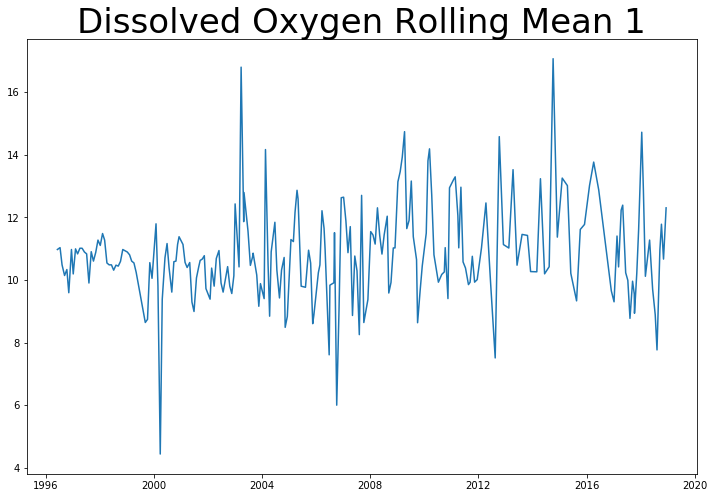

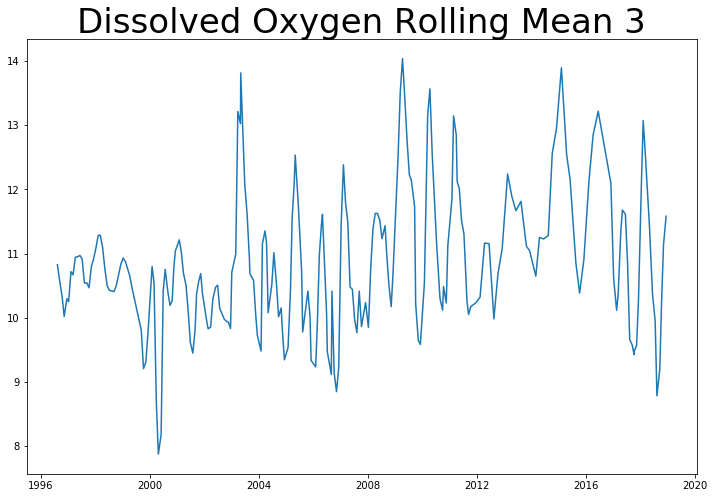

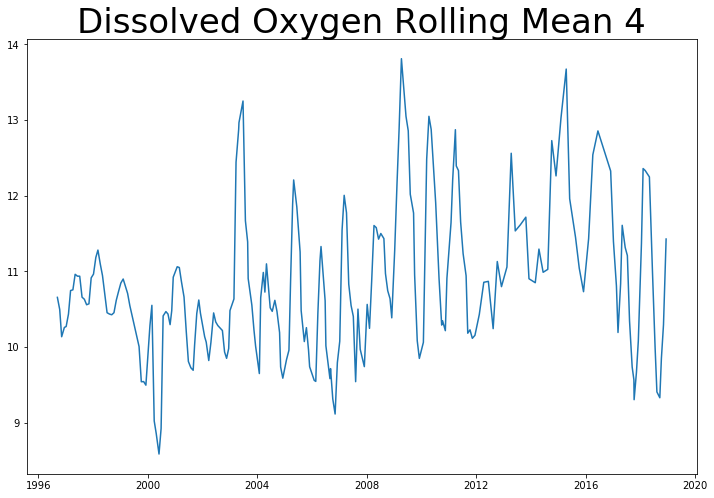

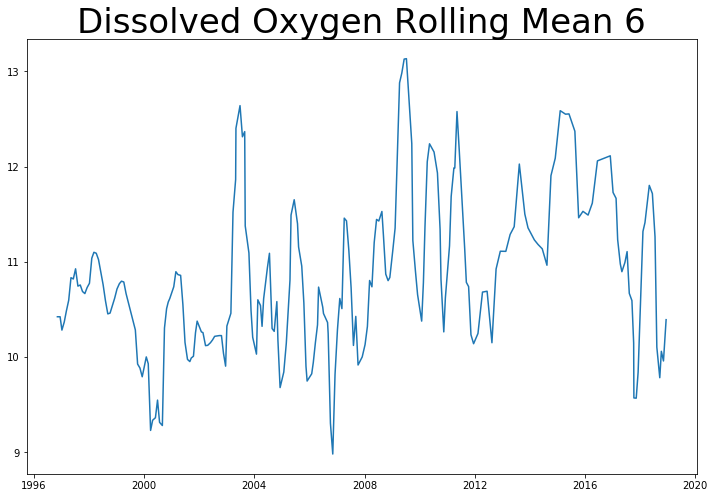

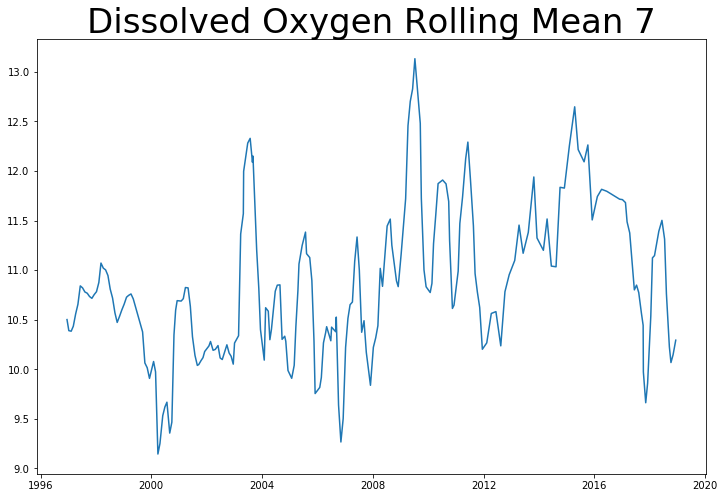

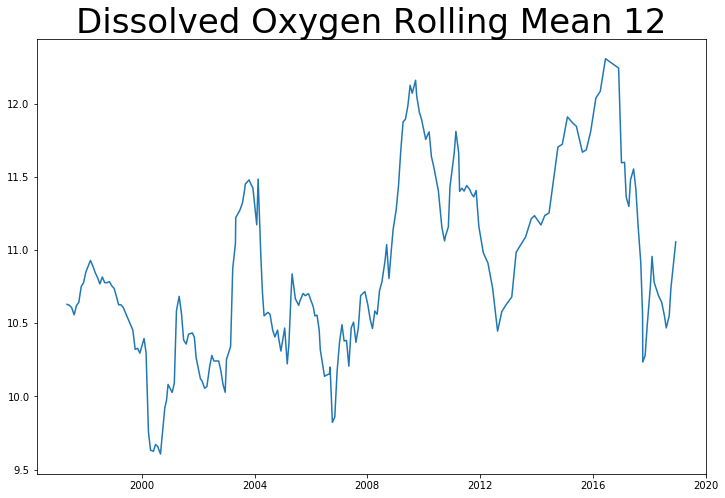

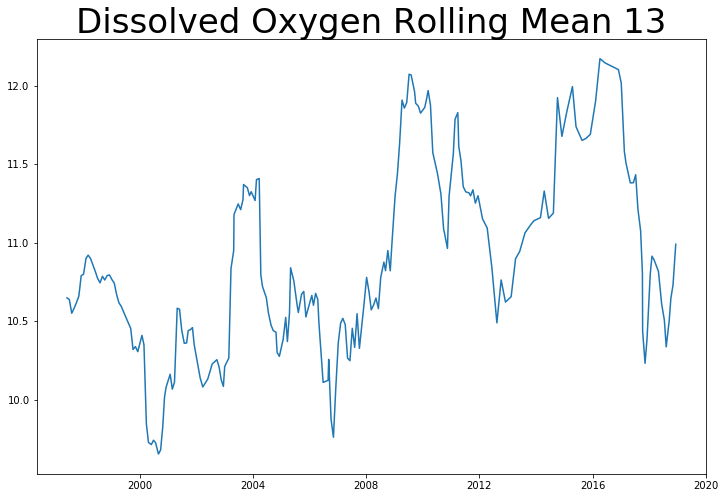

In [9]:
#creating a for loop to review rolling means
for num in [1,3,4,6,7,12,13]:
    fig = plt.figure(figsize=(12, 8))
    #plotting rolling mean with steps in for loop
    plt.plot(do_data['dissolved_oxygen'].rolling(num).mean())
    #setting title
    plt.title(f'Dissolved Oxygen Rolling Mean {num}', fontsize = 34)
    plt.show()

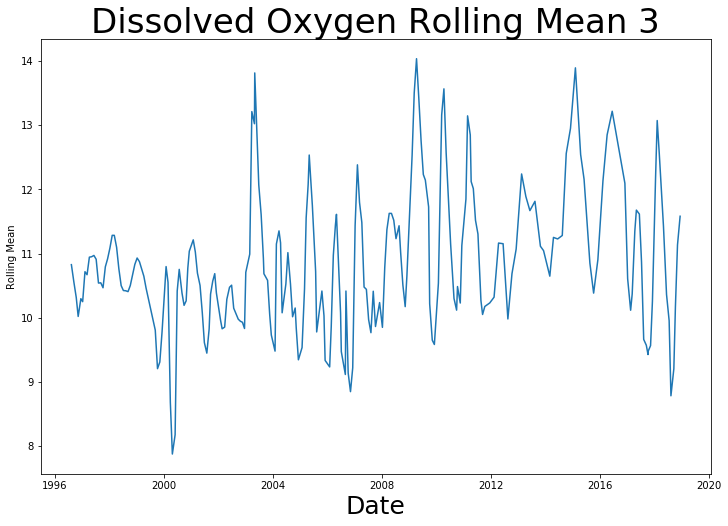

In [10]:
#creating plot for presentation

fig = plt.figure(figsize=(12, 8))
plt.plot(do_data['dissolved_oxygen'].rolling(3).mean())
plt.title(f'Dissolved Oxygen Rolling Mean 3', fontsize = 34)
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Rolling Mean')
plt.show()
fig.savefig('./Images/Rolling_mean_3.png',bbox_inches='tight')

## Dickey Fuller

In [11]:
#analyzing stationarity of the data
print("Test Stat:", adfuller(do_data['dissolved_oxygen'])[0])
print("P-Value:", adfuller(do_data['dissolved_oxygen'])[1])

Test Stat: -10.966970204751973
P-Value: 8.057773505476658e-20


## ACF and PACF

0.310007222438017


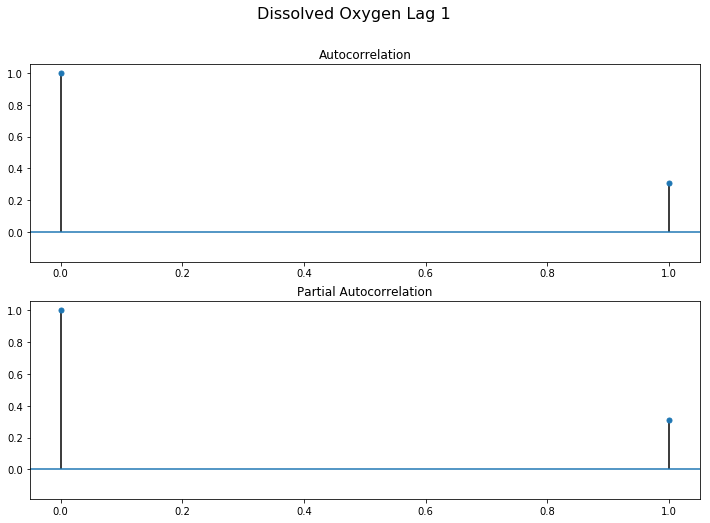

0.10515954911437742


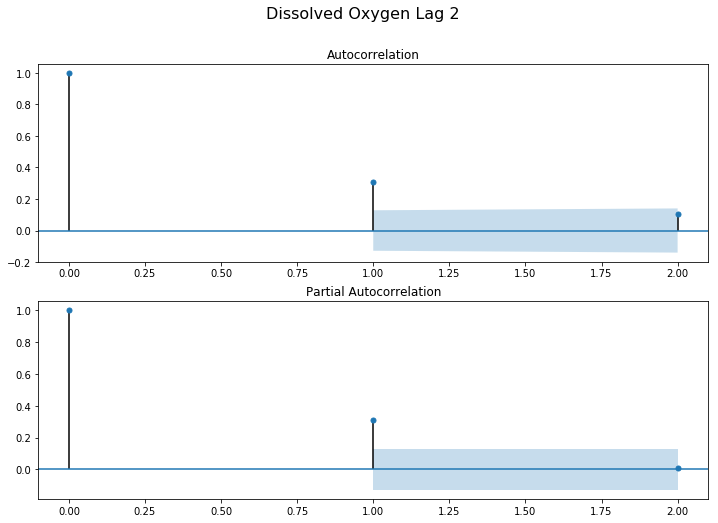

0.08355684568766548


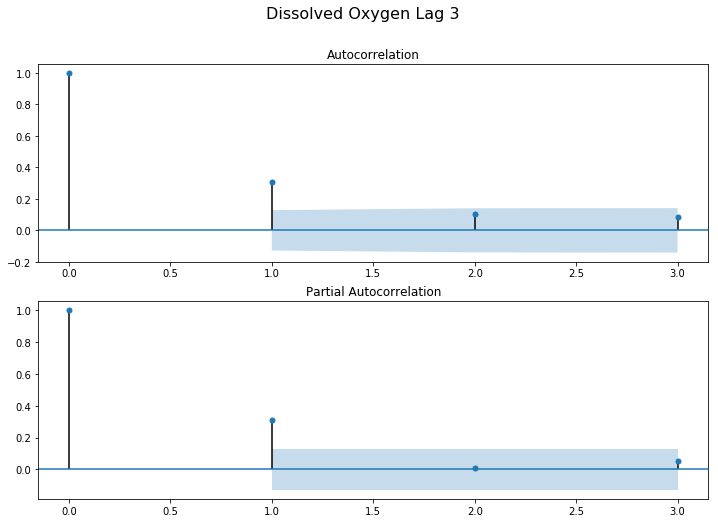

-0.0925408373419476


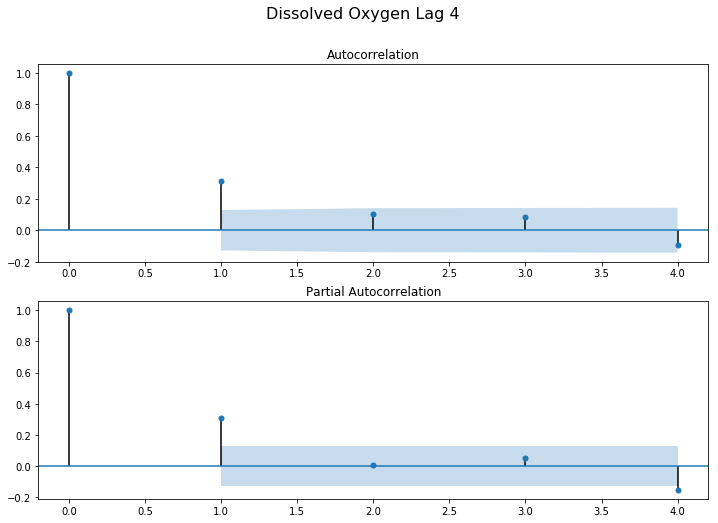

-0.04415211334280031


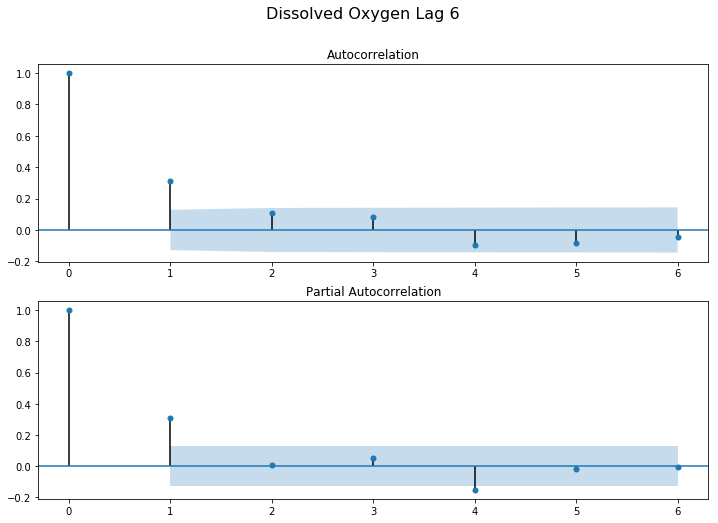

-0.0029921750241159463


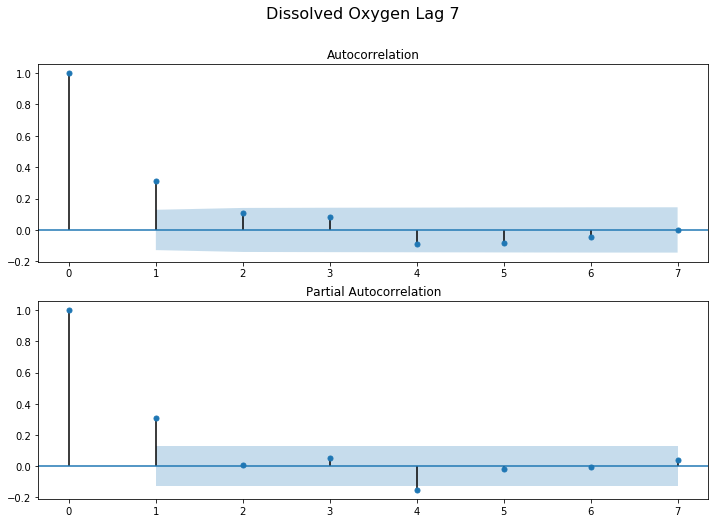

0.2427625944281364


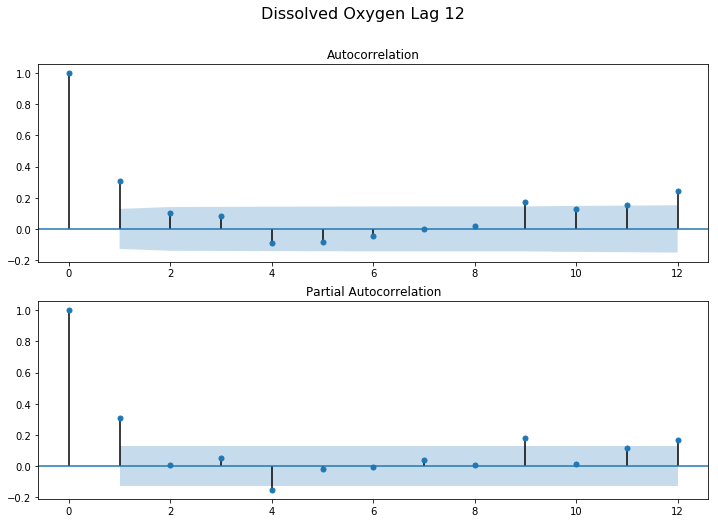

0.02606211440617367


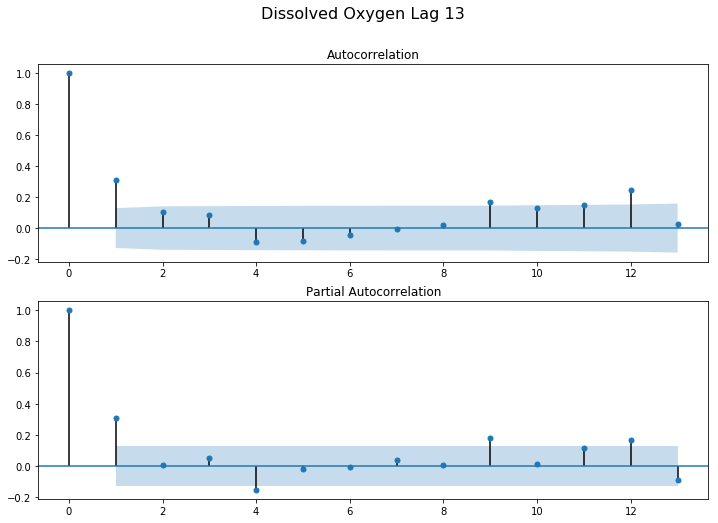

In [12]:
#reviewing acf plots for different logs
for num in [1,2,3,4,6,7,12,13]:
    acf_plot(do_data['dissolved_oxygen'],num,'Dissolved Oxygen')

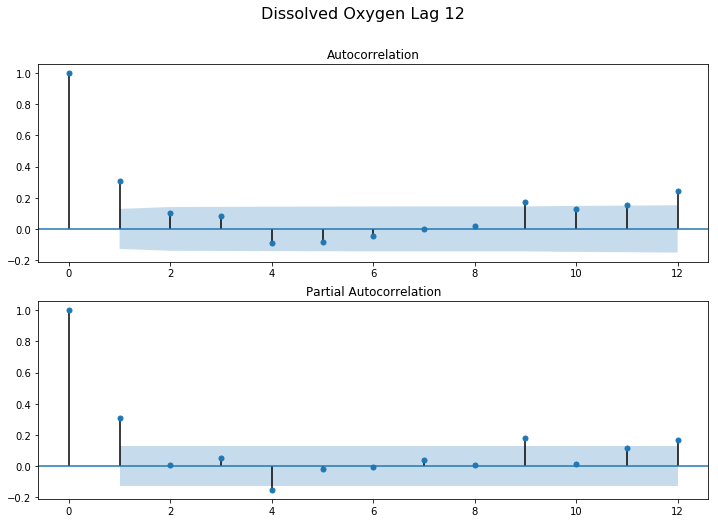

In [13]:
#creating plot for presentations
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)

fig = plot_acf(do_data['dissolved_oxygen'], lags=12, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(do_data['dissolved_oxygen'], lags=12, ax=ax2)
fig.suptitle(f'Dissolved Oxygen Lag 12', fontsize=16)
plt.show()
fig.savefig('./Images/acf_pacf_12.png',bbox_inches='tight')

## Train Test

In [14]:
#identifying shape of training set
do_data.shape[0] * .8

186.4

In [6]:
#Slitting data into training and testing shapes
train = do_data.iloc[0:186]
test = do_data.iloc[186:]

In [16]:
test.shape

(47, 2)

In [17]:
train.shape

(186, 2)

In [18]:
do_data.shape

(233, 2)

## Modeling

In [19]:
#finding baseline
train.dissolved_oxygen.mean()

10.739188723462918

In [20]:
# Checking different param models and reviewing metrics with d of 1
parameters = []
for num in [3,4,8,11]:
    for intg in [0,1,2]:
        for i in [2,3,4]:
            for n in [3,4,5]:
                    params = sarimax_eval(train, test, train['dissolved_oxygen'], test['dissolved_oxygen'],
                                          start=186, end=232, p=num, d=1, q=intg, P=i, D=0, Q=n, S=12)
                    parameters.append(params)
    
    

In [21]:
#Making model evaluation dataframe and then review top preforming models
parameters_df = pd.DataFrame(parameters)
parameters_df.sort_values(ascending = True, by = 'mae').head()

,D,P,Q,S,d,mae,p,q
24,0,4,3,12,1,1.224938,3,2
51,0,4,3,12,1,1.229332,4,2
42,0,4,3,12,1,1.233564,4,1
15,0,4,3,12,1,1.237515,3,1
78,0,4,3,12,1,1.245316,8,2


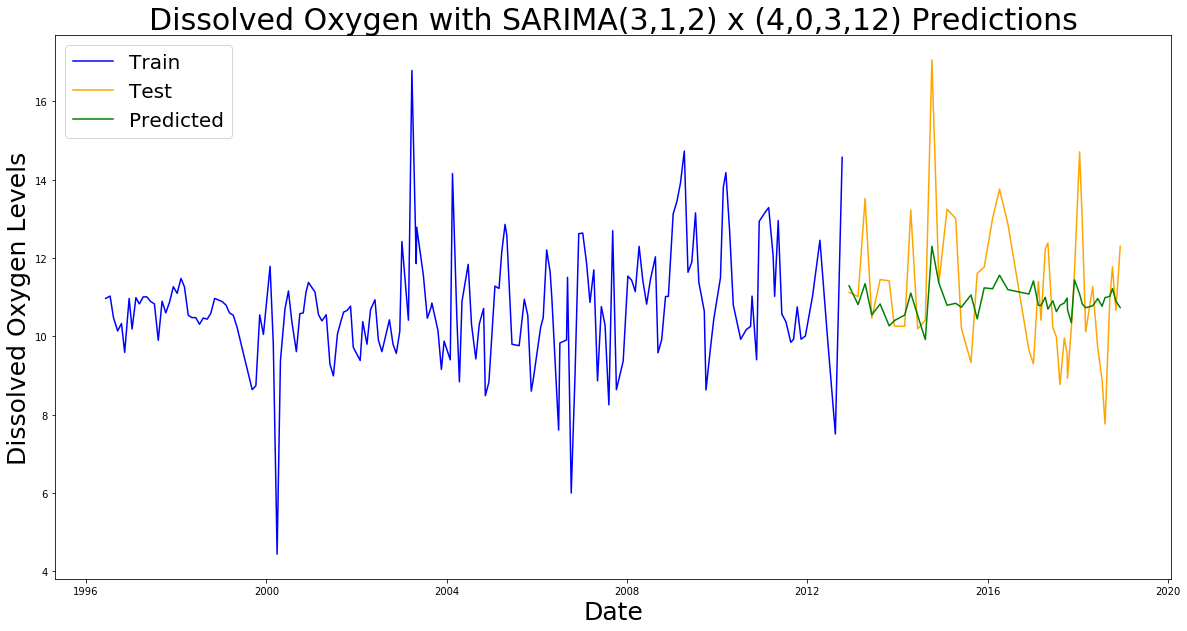

In [7]:
#creating plot of best preforming model for presentation
sarima = SARIMAX(endog = train['dissolved_oxygen'],
                     order = (3,1,2),              # (p, d, q)
                     seasonal_order=(4,0,3,12),
                     enforce_stationarity=False,
                     enforce_invertibility=False)# (P, D, Q, S))

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.

preds = model.predict(start=186,end=232)


# Plot data.
fig=plt.figure(figsize=(20,10))
plt.plot(train.index, train['dissolved_oxygen'], color = 'blue')
plt.plot(test.index, test['dissolved_oxygen'], color = 'orange')
plt.plot(test.index, preds, color = 'green')
plt.title(label = f'Dissolved Oxygen with SARIMA(3,1,2) x (4,0,3,12) Predictions', fontsize=30)
plt.legend(labels = ('Train', 'Test', 'Predicted'), fontsize=20, loc = 'upper left')
plt.xlabel('Date', fontsize=25)
plt.ylabel('Dissolved Oxygen Levels', fontsize=25)
plt.show();
fig.savefig('./Images/SARIMAX312.png',bbox_inches='tight')

In [23]:
# Checking different param models and reviewing metrics with d of 0
parameters0 = []
for num in [3,4,8,11]:
    for intg in [0,1,2]:
        for i in [2,3,4]:
            for n in [3,4,5]:
                    params = sarimax_eval(train, test, train['dissolved_oxygen'], test['dissolved_oxygen'],
                                          start=186, end=232, p=num, d=0, q=intg, P=i, D=0, Q=n, S=12)
                    parameters0.append(params)

In [24]:
#Making model evaluation dataframe and then review top preforming models
parameters0_df = pd.DataFrame(parameters0)
parameters0_df.sort_values(ascending = True, by = 'mae').head()

,D,P,Q,S,d,mae,p,q
50,0,3,5,12,0,1.245989,4,2
0,0,2,3,12,0,1.251763,3,0
25,0,4,4,12,0,1.259360,3,2
16,0,4,4,12,0,1.264031,3,1
104,0,3,5,12,0,1.264482,11,2


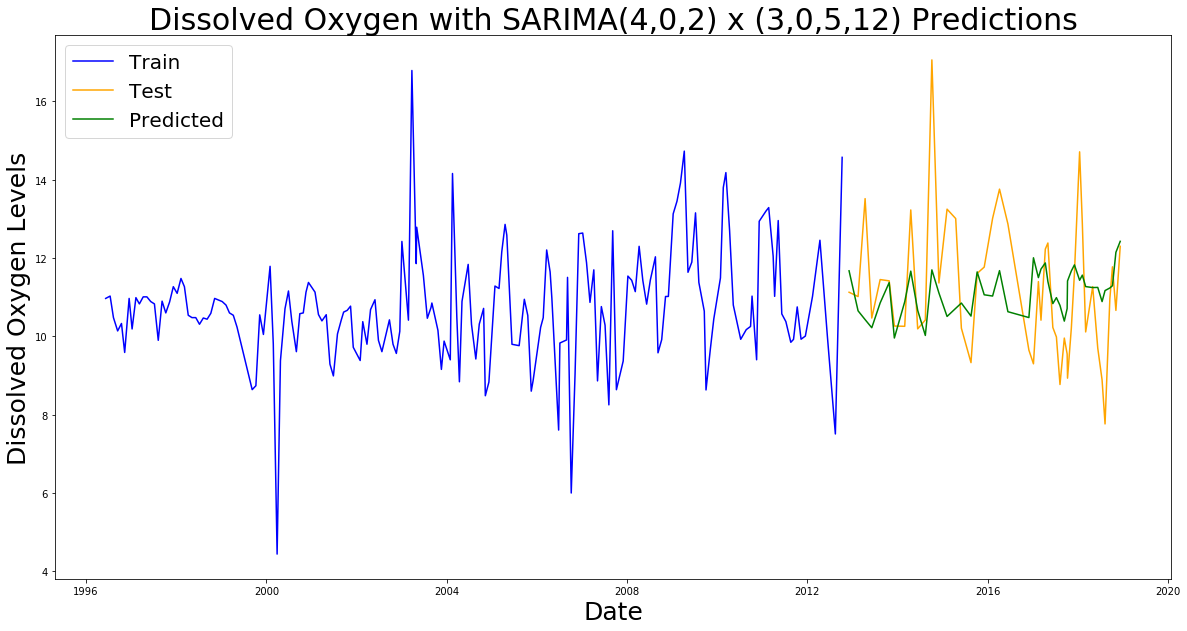

In [8]:
#creating plot of best preforming model for presentation
sarima = SARIMAX(endog = train['dissolved_oxygen'],
                     order = (4,0,2),              # (p, d, q)
                     seasonal_order=(3,0,5,12),
                     enforce_stationarity=False,
                     enforce_invertibility=False)# (P, D, Q, S))

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.

preds = model.predict(start=186,end=232)


# Plot data.
fig=plt.figure(figsize=(20,10))
plt.plot(train.index, train['dissolved_oxygen'], color = 'blue')
plt.plot(test.index, test['dissolved_oxygen'], color = 'orange')
plt.plot(test.index, preds, color = 'green')
plt.title(label = f'Dissolved Oxygen with SARIMA(4,0,2) x (3,0,5,12) Predictions', fontsize=30)
plt.legend(labels = ('Train', 'Test', 'Predicted'), fontsize=20, loc = 'upper left')
plt.xlabel('Date', fontsize=25)
plt.ylabel('Dissolved Oxygen Levels', fontsize=25)
plt.show();
fig.savefig('./Images/SARIMAX402.png',bbox_inches='tight')

In [26]:
#evaluating the best preforming model compared to baseline
1.22/10.73

0.11369990680335507

In [27]:
#forecast forward based on the data we have and best preforming model
sarima = SARIMAX(do_data['dissolved_oxygen'],
                                order=(3, 1, 2),
                                seasonal_order=(4, 0, 3, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = sarima.fit()
#preducing forecasts
pred_uc = results.get_forecast(steps=12)



In [28]:
#Show the predictions
pred_uc.summary_frame()

dissolved_oxygen,mean,mean_se,mean_ci_lower,mean_ci_upper
233,12.657800,1.418610,9.877374,15.438225
234,12.391092,1.471148,9.507694,15.274489
235,12.118088,1.474089,9.228927,15.007249
236,11.025860,1.480421,8.124289,13.927432
237,10.793230,1.480653,7.891204,13.695257
238,10.279456,1.482331,7.374142,13.184770
239,10.434176,1.482609,7.528316,13.340036
240,10.083808,1.483385,7.176427,12.991189
241,11.292642,1.483474,8.385087,14.200196
242,11.644566,1.483683,8.736600,14.552532


In [29]:
#saving data used for analysis to csv
do_data.to_csv('./Data/DO_data.csv')